# Imports

In [1]:
import os; os.chdir('..')
%load_ext autoreload
%autoreload 2

In [2]:
import perustats, json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
alt.renderers.enable('notebook')
%matplotlib inline

In [3]:
PATH_OUT = Path('data/processed/criminality')

# Getting ratio

In [4]:
df_pop = pd.read_csv(PATH_OUT/'population_inei.csv')
df_pop = df_pop.set_index(['ambito', 'indicador'])['2015'].fillna(0).unstack().reset_index()
df_pop.columns.name = None
df_pop['poblacion_total'] = df_pop.poblacion_total_rural + df_pop.poblacion_total_urbana

df = pd.read_csv(PATH_OUT/'tipo-ubicacion.csv')
df.loc[df.departamento == 'Lima Provincias', 'departamento'] = 'Lima'
df = (df.groupby(['year', 'departamento', 'variable']).sum().reset_index().
          merge(df_pop, 'left', left_on='departamento', right_on='ambito').
          assign(ratio = lambda x: x.value / x.poblacion_total).
          assign(poblacion = lambda x: x.poblacion_total).
          set_index(['year', 'departamento', 'variable'])[['value', 'ratio', 'poblacion']])

df.head()

value  \
year departamento variable                                                
2015 Amazonas     delitos-contra-el-estado-y-la-defensa-nacional      3   
                  delitos-contra-el-honor                            10   
                  delitos-contra-el-orden-economico                   1   
                  delitos-contra-el-orden-financiero-y-monetario     10   
                  delitos-contra-el-patrimonio                     1426   

                                                                     ratio  \
year departamento variable                                                   
2015 Amazonas     delitos-contra-el-estado-y-la-defensa-nacional  0.000007   
                  delitos-contra-el-honor                         0.000024   
                  delitos-contra-el-orden-economico               0.000002   
                  delitos-contra-el-orden-financiero-y-monetario  0.000024   
                  delitos-contra-el-patrimonio                    0.003374   

                                                                  poblacion  
year departamento variable                                                   
2015 Amazonas     delitos-contra-el-estado-y-la-defensa-nacional   422629.0  
                  delitos-contra-el-honor                          422629.0  
                  delitos-contra-el-orden-economico                422629.0  
                  delitos-contra-el-orden-financiero-y-monetario   422629.0  
                  delitos-contra-el-patrimonio                     422629.0

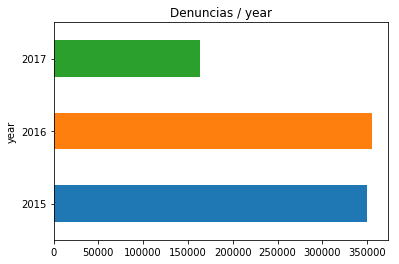

In [5]:
df.groupby('year')['value'].sum().plot.barh(title='Denuncias / year');

As 2017 seems to have missing data, I will mainly use 2016 data.

In [6]:
df_2016 = df.loc[2016].reset_index()

# Summary plot

In [7]:
df_2016['dep_ratio'] = df_2016.value / df_2016.departamento.map(df_2016.groupby('departamento')['value'].sum())
df_2016['var_ratio'] = df_2016.value / df_2016.value.sum()
df_2016.head(2)

,departamento,variable,value,ratio,poblacion,dep_ratio,var_ratio
0,Amazonas,delitos-contra-el-estado-y-la-defensa-nacional,1,0.000002,422629.0,0.000299,0.000003
1,Amazonas,delitos-contra-el-honor,8,0.000019,422629.0,0.002395,0.000022


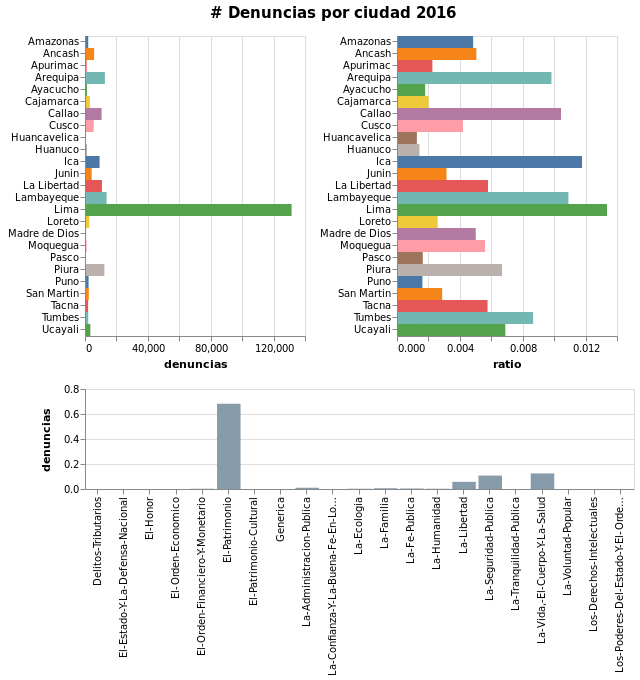

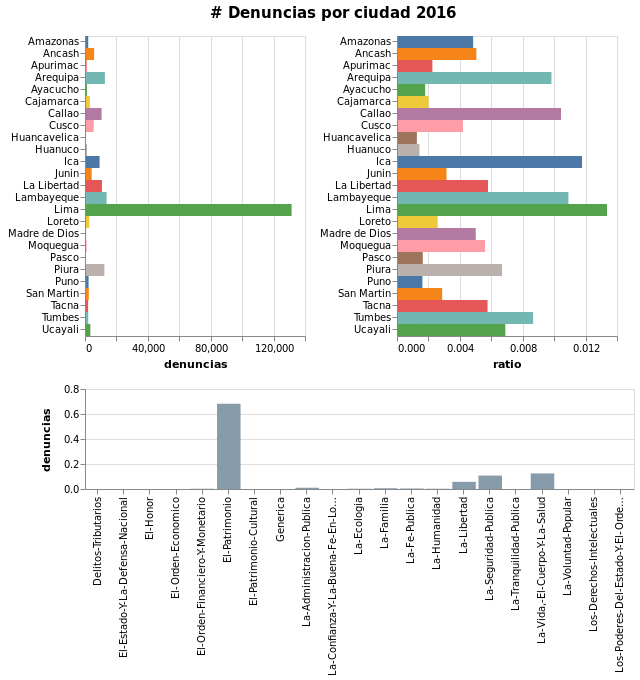

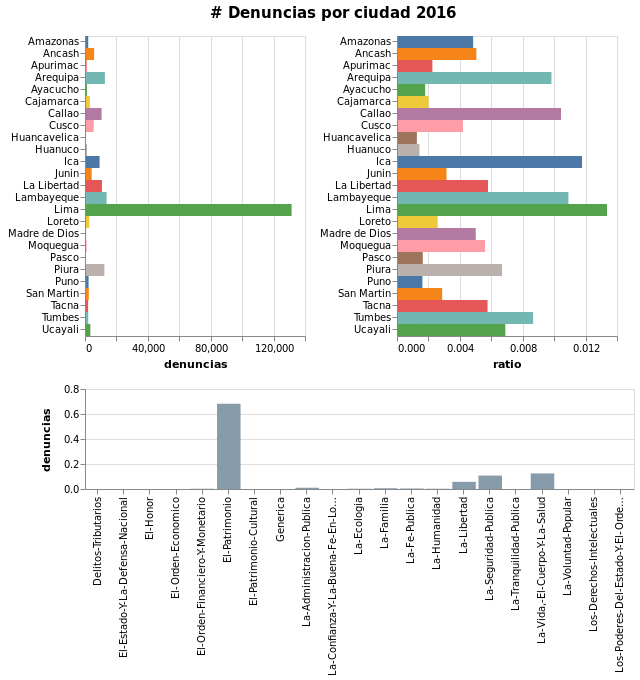

In [11]:
select = alt.selection_single(on='mouseover', fields=['departamento'])
select_text = alt.selection_single(on='mouseover', fields=['departamento'], empty='none')
tooltip = alt.selection_single(on='mouseover', fields=['variable'], empty='none')

base = alt.Chart(
    df_2016.assign(variable = lambda x: x.variable.str.replace('delitos-contra-', '').str.title())
).mark_bar(size=12).encode(
    y=alt.Y('departamento', title=None),
    color=alt.condition(select, 'departamento', alt.value('lightgray'), legend=None)
)

p1 = base.encode(
    x=alt.X('value', title='denuncias'),
).properties(
    selection=select,
    width = 220, height=300
)

p1 = (p1 + p1.encode(opacity=alt.value(0)).properties(selection=select_text))

p2 = base.encode(
    x='ratio',
).properties(
    selection=select,
    width = 220, height=300
)

p2 = (p2 + p2.encode(opacity=alt.value(0)).properties(selection=select_text))

p3 = base.mark_bar().encode(
    x=alt.X('variable', title=None),
    y=alt.Y('sum(var_ratio)', title='denuncias', scale=alt.Scale(domain=[0,.8])),
    color=alt.condition(tooltip, alt.ColorValue('#4a708b'), alt.value('#879cab'))
).properties(
    width=549, height=100
)

p3_sel = p3.mark_bar(size=10).encode(
    y=alt.Y('mean(dep_ratio)', title='denuncias'),
    color=alt.ColorValue('goldenrod'), opacity=alt.value(0.75)
).transform_filter(select_text)

p3_text = p3.mark_text(align='left', dx=5, dy=-5, fontSize=11).encode(
    text=alt.condition(tooltip, 'variable', alt.value(' ')),
    color=alt.ColorValue('black')
).properties(selection=tooltip)

p3_city = p3.mark_text(align='right', fontSize=14).encode(
    x=alt.value(500), y=alt.value(18),
    text='departamento', color=alt.ColorValue('black')
).transform_filter(select_text)

chart = alt.vconcat((p1 | p2), (p3 + p3_sel + p3_text + p3_city), title='                         # Denuncias por ciudad 2016')
chart = chart.configure(title=alt.VgTitleConfig(fontSize=15, offset=15))
chart.save('reports/charts/delitos-denuncias2016.html')
chart

# Some explorations

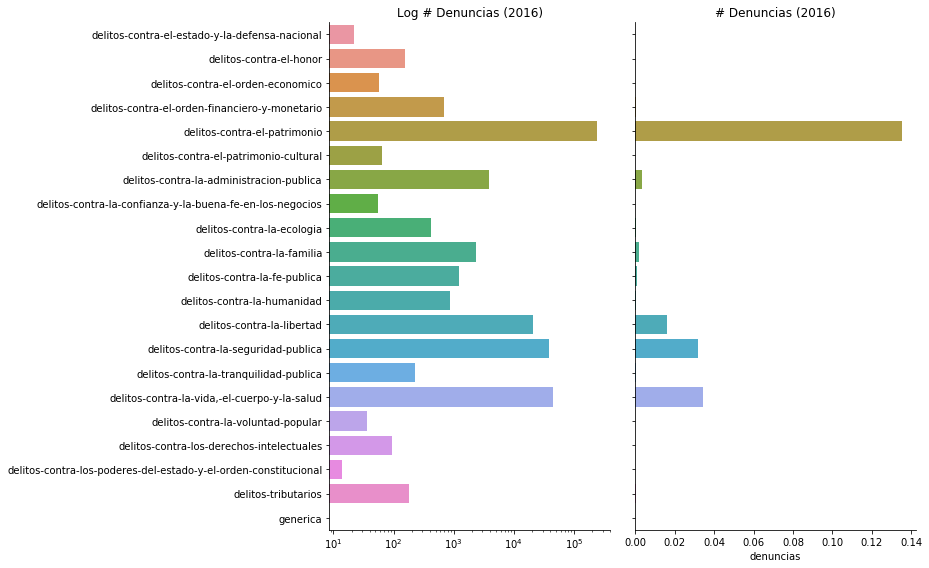

In [173]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(13,8))

df_denuncias = (df.loc[2016].
                   groupby('variable').
                   agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
                   reset_index().
                   assign(value_perc=lambda x: x.value / x.value.sum()))

sns.barplot(df_denuncias.value, df_denuncias.variable, ax=axes[0])
axes[0].set_title('Log # Denuncias (2016)')
axes[0].set_xlabel('')
axes[0].set_xscale('log')

sns.barplot(df_denuncias.ratio, df_denuncias.variable, ax=axes[1])
axes[1].set_title('# Denuncias (2016)')
axes[1].set_xlabel('denuncias')

for ax in axes: ax.set_ylabel('')
plt.tight_layout()
sns.despine()

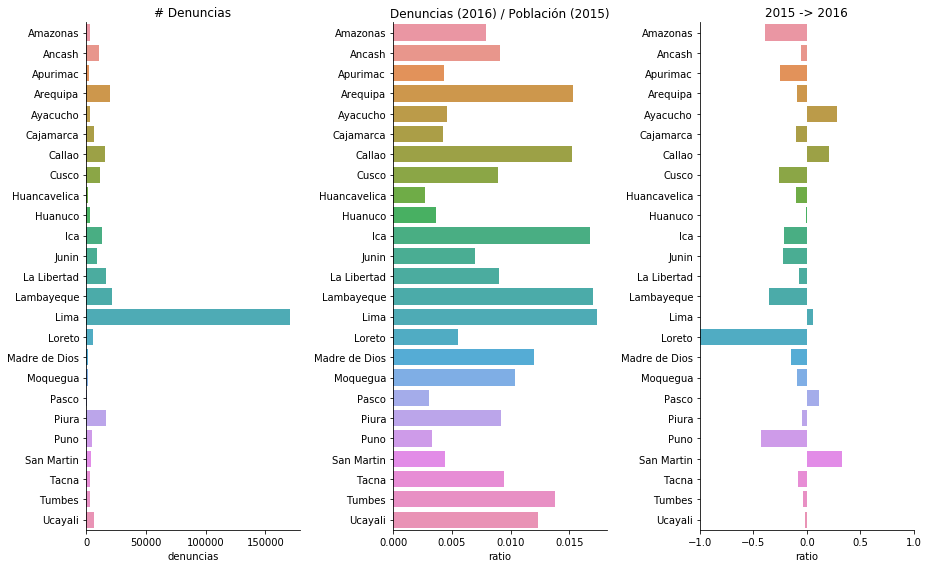

In [174]:
fig, axes = plt.subplots(1, 3, figsize=(13,8))

df_departments = (df.loc[2016].
                     groupby('departamento').
                     agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
                     reset_index())

sns.barplot(df_departments.value, df_departments.departamento, ax=axes[0])
axes[0].set_title('# Denuncias')
axes[0].set_xlabel('denuncias')

sns.barplot(df_departments.ratio, df_departments.departamento, ax=axes[1])
axes[1].set_title('Denuncias (2016) / Población (2015)')
axes[1].set_xlabel('ratio')

t = df.groupby(['year', 'departamento'])['value'].sum()
t = ((t[2015] - t[2016]) / t[2015]).reset_index()
sns.barplot('value', 'departamento', data=t, ax=axes[2])
axes[2].set_title('2015 -> 2016')
axes[2].set_xlabel('ratio')
axes[2].set_xlim(-1,1)

for ax in axes: ax.set_ylabel('')
plt.tight_layout()
sns.despine()

# PCA

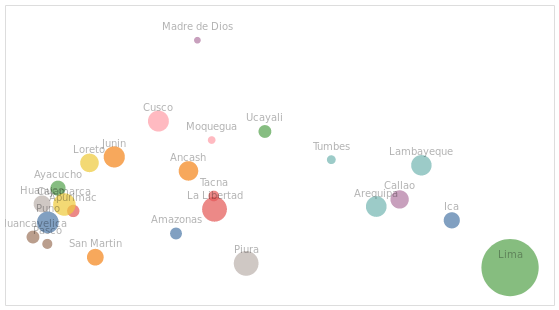

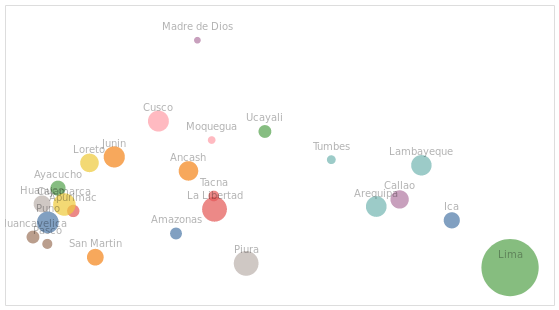

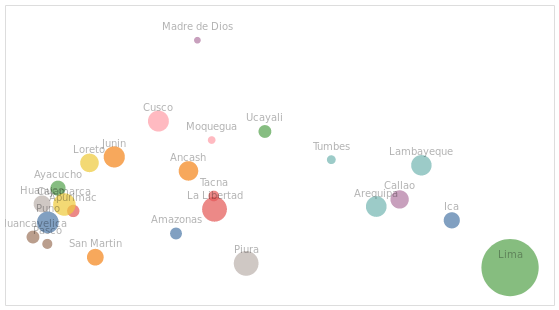

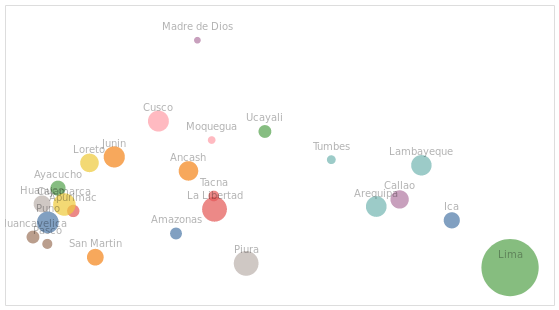

In [510]:
t = df.loc[2016, 'ratio'].unstack(0).T
pca = PCA(2)
t_pca = pca.fit_transform(t)
region_pca = pd.DataFrame(t_pca, columns=['c1', 'c2'])
region_pca['region'] = t.index
region_pca['poblacion'] = region_pca.region.map(df.loc[2016, 'poblacion'].mean(level=0))

select = alt.selection_single(fields=['c1', 'c2'], empty='none', on='mouseover')
limits = region_pca.poblacion.quantile([0, 0.6]).tolist()

base = alt.Chart(region_pca).encode(
    alt.X('c1', scale=alt.Scale(domain=[region_pca.c1.min(), region_pca.c1.max()*1.1]), axis=None),
    alt.Y('c2', axis=None)
).properties(width=549)

p_circles = base.mark_circle().encode(
    alt.Size('poblacion', scale=alt.Scale(domain=limits), legend=None),
    alt.Color('region', legend=None)
).properties(selection=select).interactive()

p_text = base.mark_text(dy=-10).encode(
    text='region',
    opacity=alt.condition(select, alt.value(1.0), alt.value(0.3)),
    size=alt.condition(select, alt.value(12), alt.value(10))
)

chart = p_circles + p_text
chart.save('reports/charts/delitos-pca.html')
chart

In [513]:
pca.explained_variance_ratio_

array([0.95466442, 0.0336176 ])

# Heatmaps

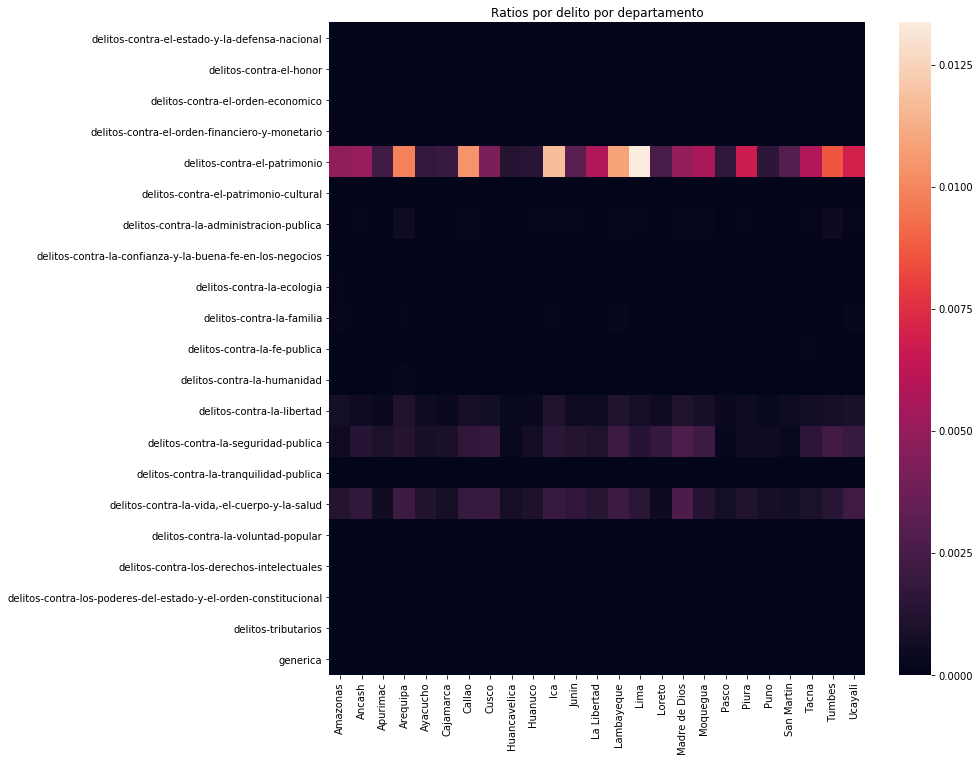

In [516]:
plt.figure(figsize=(12,12))
sns.heatmap(t.T)
plt.xlabel(''); plt.ylabel('')
plt.title('Ratios por delito por departamento');

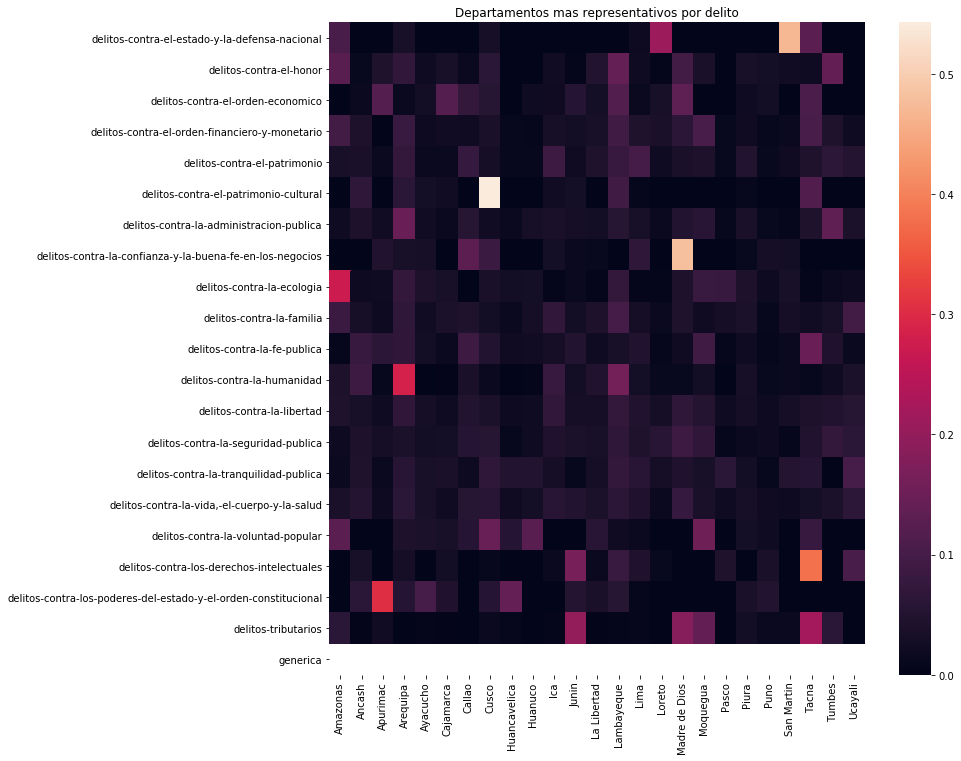

In [517]:
plt.figure(figsize=(12,12))
t = df.loc[2016, 'ratio'].unstack(0).T
sns.heatmap(t.apply(lambda x: x/x.sum(), axis=0).T)
plt.xlabel(''); plt.ylabel('')
plt.title('Departamentos mas representativos por delito');

# Maps

In [674]:
geos = (gpd.read_file('data/raw/peru_departamental_simple.geojson').
            assign(NOMBDEP=lambda x: x.NOMBDEP.str.title().str.replace('De', 'de')).
            merge(df_departments, 'left', left_on='NOMBDEP', right_on='departamento').
            set_index('NOMBDEP').
            loc[:, ['geometry', 'value', 'ratio', 'poblacion']])
centers = geos.geometry.centroid.apply(lambda x: x.xy)
geos['lat'] = centers.apply(lambda x: x[1][0])
geos['lon'] = centers.apply(lambda x: x[0][0])
geos.head(2)

,geometry,value,ratio,poblacion,lat,lon
NOMBDEP,,,,,,
Amazonas,POLYGON ((-77.75893361195118 -6.96450785011829...,3340,0.007903,422629.0,-5.069303,-78.053978
Ancash,POLYGON ((-77.31748636153681 -8.53015235157666...,10446,0.009094,1148634.0,-9.406108,-77.670122


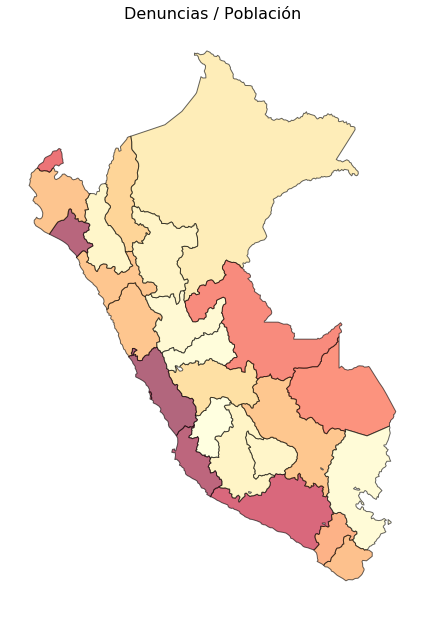

In [790]:
fig, ax = plt.subplots(1, 1, figsize=(6,9))

geos.plot(column='ratio', cmap='YlOrRd',
          legend=False, alpha=.6, edgecolor='black', ax=ax)
ax.set_title('Denuncias / Población',
             fontdict={'fontsize': 16})

ax.set_xticks([]);ax.set_yticks([]);ax.set_aspect('equal')
sns.despine(left=True, bottom=True)
plt.tight_layout()
fig.savefig('reports/charts/delitos-ratio-map.png')

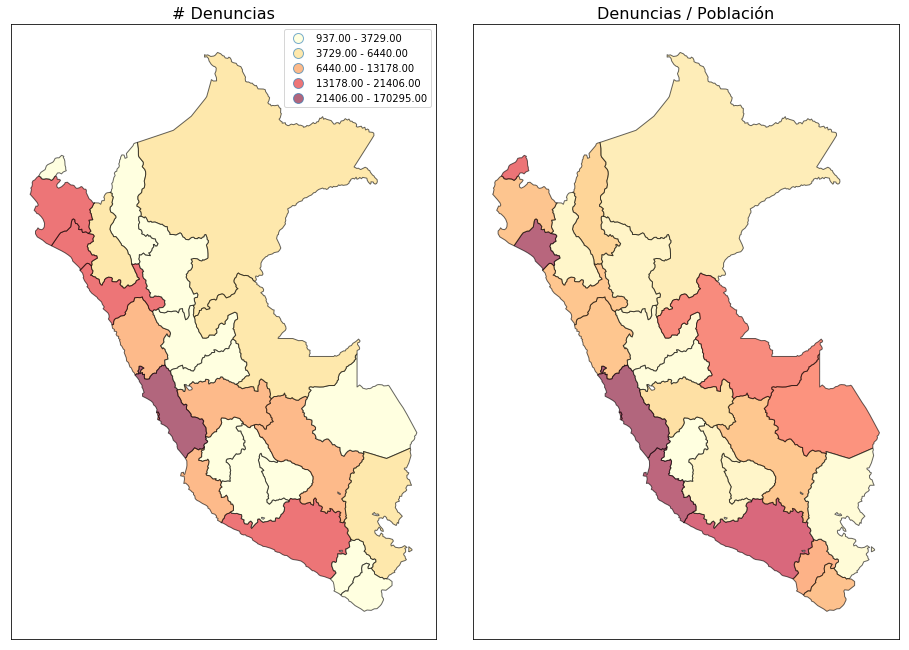

In [786]:
fig, axs = plt.subplots(1, 2, figsize=(13,9))

titles = ['# Denuncias', 'Denuncias / Población']
geos.plot(column='value', cmap='YlOrRd', scheme='Fisher_Jenks',
          legend=True, alpha=.6, edgecolor='black', ax=axs[0])
geos.plot(column='ratio', cmap='YlOrRd',# scheme='Fisher_Jenks',
          legend=False, alpha=.6, edgecolor='black', ax=axs[1])

for ax,t in zip(axs,titles):
    ax.set_title(t, fontdict={'fontsize': 16}); ax.set_xticks([]);ax.set_yticks([]);ax.set_aspect('equal')
    
plt.tight_layout()

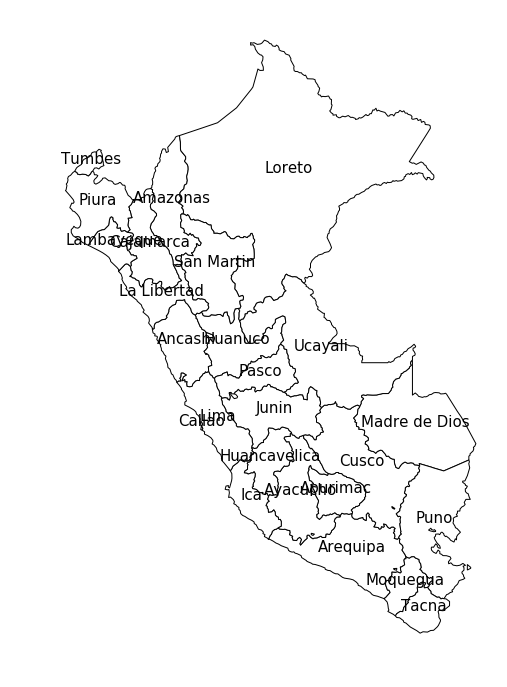

In [235]:
geos.plot(edgecolor='black', color='white', figsize=(12,12))
for n, [x,y] in geos.geometry.centroid.apply(lambda x: [x.xy[0][0], x.xy[1][0]]).items():
    plt.text(x, y, n, color='#000000', fontsize=15, horizontalalignment='center')
plt.axis('off');

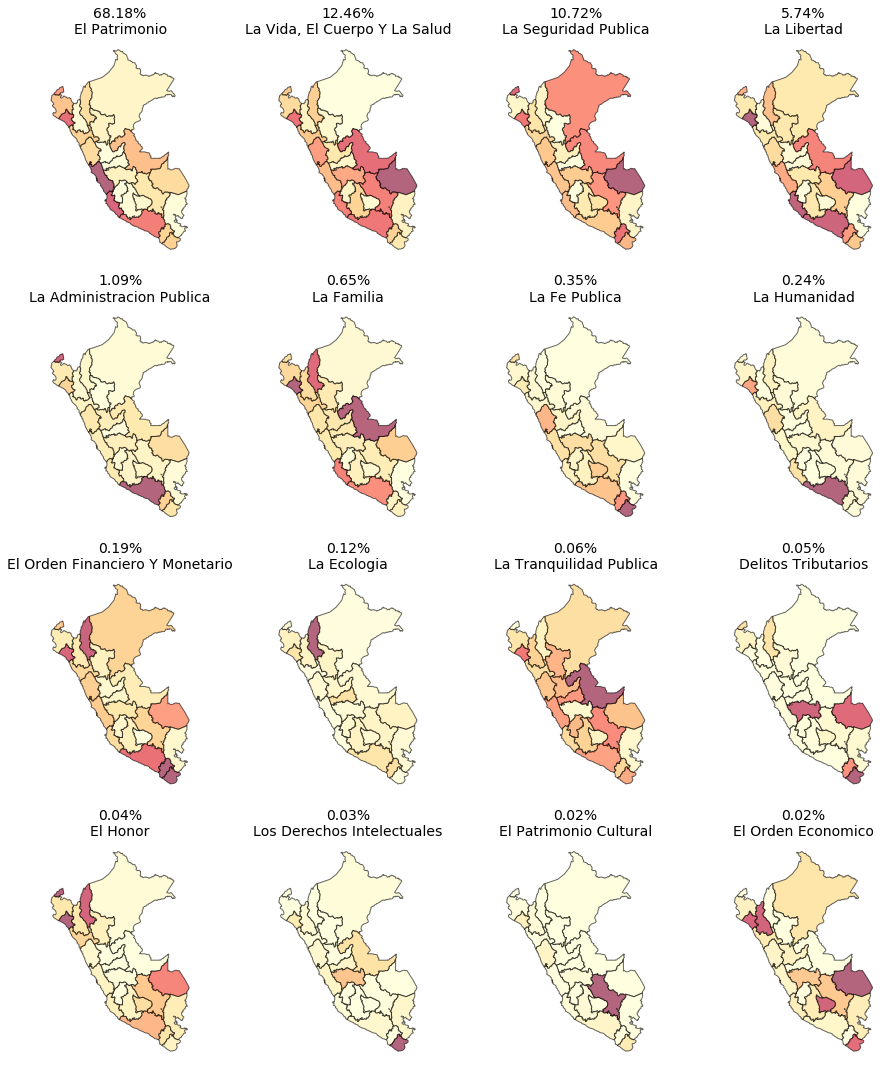

In [813]:
fig, axes = plt.subplots(4, 4, figsize=(13,15))

for ax,e in zip(axes.flatten(), df_denuncias.sort_values('value', ascending=False).variable):
    v = df_denuncias.query(f'variable == {e!r}').value_perc.iloc[0] * 100
    df_t = (df.loc[pd.IndexSlice[2016,:,e]].
               groupby('departamento').
               agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
               reset_index())
    df_t = (geos[['geometry']].
               merge(df_t, 'left', left_index=True, right_on='departamento'))
    df_t.plot(column='ratio', cmap='YlOrRd',
              legend=False, alpha=.6, edgecolor='black', ax=ax)
    ax.set_title(f'{v:.2f}%\n{e.replace("delitos-contra-", "").replace("-"," ")}'.title(),
                 fontdict={'fontsize': 14})
    ax.set_xticks([]);ax.set_yticks([]);ax.set_aspect('equal')
    ax.set_axis_off()
    
plt.tight_layout()
fig.savefig('reports/charts/delitos-crim-maps.png')